In [196]:
import pandas as pd 
import numpy as np         
import matplotlib.pyplot as plt  

from datetime import datetime   

from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from numpy import array
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline 

import warnings                  
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [317]:
dataset = pd.read_csv('Data/airline-passengers.csv', engine='python')

In [318]:
dataset.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


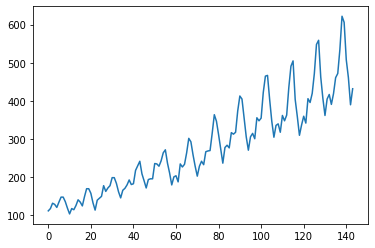

In [319]:
plt.plot(dataset['Passengers']);

#### Preprocess data
We will use the passenger count and month information as an input to the model. <br>
It's generally a good practice to **Scale** your data before using it as input to a neural network, especially when dealing with features that have different scales or magnitudes. we are using 'MinMaxScaler' to scales both "Passengers" and "Month" to the [0, 1] range. 

In [320]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset['Month'] = dataset['Month'].dt.month
dataset_values = dataset[['Passengers', 'Month']].values.astype('float32') #convert the integer values to floating point values, which are more suitable for modeling with a neural network.


In [309]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_values = scaler.fit_transform(dataset_values)

#### Split into train and test sets

In [321]:
train_size = int(len(dataset_values) * 0.67)
test_size = len(dataset_values) - train_size
train, test = dataset_values[0:train_size], dataset_values[train_size:len(dataset_values)]
print(len(train), len(test))

96 48


In [340]:
# convert an array of values into a dataset matrix
# look_back: number of previous time steps to use as input variables to predict the next time period—in this case, defaulted to 1.
# output: X is the number of passengers at a given time (t), and Y is the number of passengers at the next time (t + 1).
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [341]:
look_back = 2   #you are creating input sequences of length 2 (i.e., two time steps)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

#### The input to an LSTM network typically consists of a 3D tensor with the shape (batch_size, timesteps, input_features).

Samples: number of individual data points in your dataset <br>
Time steps : the number of data points in each sequence. It determines how far back in time the model looks when making predictions. <br>
Features : the number of features 

In [347]:
trainX.shape #[samples, time steps, features]

(93, 2, 2)

In [345]:
# # Reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[1]))

#### Stacked LSTM Model

In the first LSTM layer 'return_sequences=True' means it will return the full sequence of output,  which is necessary if you want to stack LSTM layers.

In [348]:
stacked_model = Sequential()
stacked_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, trainX.shape[2])))
stacked_model.add(LSTM(50, activation='relu'))
stacked_model.add(Dense(1))
stacked_model.compile(optimizer='adam', loss='mse')

# fit model
stacked_model.fit(trainX, trainY, epochs=200, verbose=0)

In [357]:
scaled_passenger_value = scaler.transform(np.array([[112, 3]]))
input_sequence = np.pad(scaled_passenger_value, ((0, 1), (0, 0)), mode='constant', constant_values=0)
input_sequence = input_sequence.reshape(1, 2, 2) 

predicted_scaled_value = stacked_model.predict(input_sequence)
predicted_population_count = scaler.inverse_transform(np.array([[predicted_scaled_value[0, 0], 3]]))
print("Predicted Population Count:", predicted_population_count[0, 0])


1/1 [==============================] - 0s 247ms/step
Predicted Population Count: 206.3245250751


#### Bidirectional LSTM

In [354]:
Bi_model = Sequential()
Bi_model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(look_back, trainX.shape[2])))
Bi_model.add(Dense(1))
Bi_model.compile(optimizer='adam', loss='mse')
# fit model
Bi_model.fit(trainX, trainY, epochs=200, verbose=0)

In [358]:
scaled_passenger_value = scaler.transform(np.array([[112, 3]]))
input_sequence = np.pad(scaled_passenger_value, ((0, 1), (0, 0)), mode='constant', constant_values=0)
input_sequence = input_sequence.reshape(1, 2, 2) 

predicted_scaled_value = Bi_model.predict(input_sequence)
predicted_population_count = scaler.inverse_transform(np.array([[predicted_scaled_value[0, 0], 3]]))
print("Predicted Population Count:", predicted_population_count[0, 0])

1/1 [==============================] - 0s 254ms/step
Predicted Population Count: 228.36635048726444


#### Test and Evaluate

**Mean Squared Error (MSE)** is a measure of the average squared difference between the predicted values and the actual values. A lower MSE indicates better model performance. <br>
**Root Mean Squared Error (RMSE)** is the square root of the MSE and provides a measure of the average prediction error in the same units as the target variable. A lower RMSE indicates better model performance.

In [359]:
stacked_test_predictions = stacked_model.predict(testX)
Bi_test_predictions = Bi_model.predict(testX)

2/2 [==============================] - 0s 4ms/step


In [360]:
print("Stacked Model:")
mse = mean_squared_error(testY, stacked_test_predictions)
print("Mean Squared Error (MSE):", mse)

rmse = sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

print("Bidirectional Model:")
mse = mean_squared_error(testY, Bi_test_predictions)
print("Mean Squared Error (MSE):", mse)

rmse = sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Stacked Model:
Mean Squared Error (MSE): 1043.7225
Root Mean Squared Error (RMSE): 32.3066948817066
Bidirectional Model:
Mean Squared Error (MSE): 1644.1216
Root Mean Squared Error (RMSE): 40.54776913754011


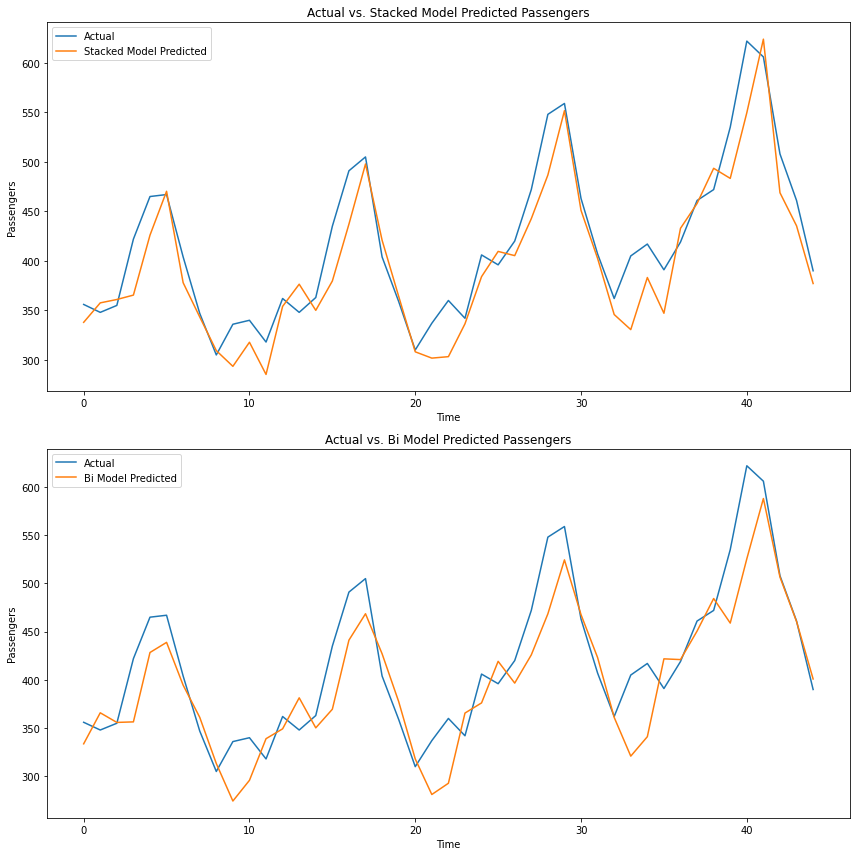

In [361]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot for Stacked Model
axes[0].plot(testY, label='Actual')
axes[0].plot(stacked_test_predictions, label='Stacked Model Predicted')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Passengers')
axes[0].legend()
axes[0].set_title('Actual vs. Stacked Model Predicted Passengers')

# Plot for Bi Model
axes[1].plot(testY, label='Actual')
axes[1].plot(Bi_test_predictions, label='Bi Model Predicted')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Passengers')
axes[1].legend()
axes[1].set_title('Actual vs. Bi Model Predicted Passengers')

plt.tight_layout() 
plt.show()